# Experiments

In [1]:
# Import.
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from models.principal_rbm_alpha import RBM
from models.principal_dbn_alpha import DBN
from models.principal_dnn_mnist import DNN
from utils import (
    load_mnist,
    load_alphadigit,
    read_alpha_digit,
    plot_characters_alphadigit,
    plot_original_and_generated_images
)

In [2]:
DATA_FOLDER = "../data/"
ALPHA_DIGIT_PATH = os.path.join(DATA_FOLDER, "binaryalphadigs.mat")
MNIST_PATH = os.path.join(DATA_FOLDER, "mnist_all.mat")

for path in [ALPHA_DIGIT_PATH, MNIST_PATH]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file {path} does not exist.")

SEED = 42

## 1. Study on BinaryAlphaDigit

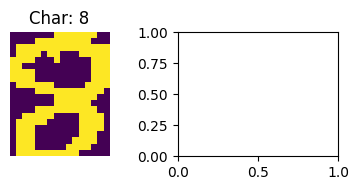

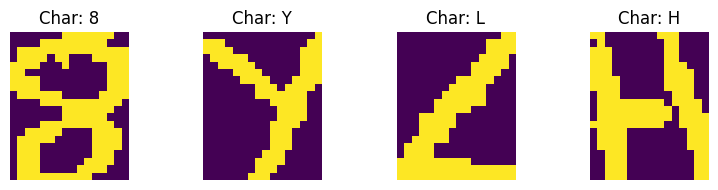

Original data: (36, 39)
Original data (unstack samples -> flatten images): (1365, 320)
Subset (1 character) data  (39, 320)
Subset (4 characters) data  (156, 320)


In [3]:
alphadigit = load_alphadigit(ALPHA_DIGIT_PATH)

chars_1 = [8]
chars_2 = chars_1 + ["Y"]
chars_3 = chars_2 + ["L"]
chars_4 = chars_3 + ["H"]
data_alpha_1 = read_alpha_digit(chars_1, data=alphadigit, use_data=True)
data_alpha_2 = read_alpha_digit(chars_2, data=alphadigit, use_data=True)
data_alpha_3 = read_alpha_digit(chars_3, data=alphadigit, use_data=True)
data_alpha_4 = read_alpha_digit(chars_4, data=alphadigit, use_data=True)

all_chars = np.arange(0, 35).tolist()
alphadigit_data = read_alpha_digit(all_chars, data=alphadigit, use_data=True) # read all characters

plot_characters_alphadigit(chars_1, data_alpha_1)
plot_characters_alphadigit(chars_4, data_alpha_4)

print("Original data:", alphadigit.shape)
print("Original data (unstack samples -> flatten images):", alphadigit_data.shape)
print(f"Subset ({len(chars_1)} character) data ", data_alpha_1.shape)
print(f"Subset ({len(chars_4)} characters) data ", data_alpha_4.shape)

### RBM

In [4]:
data_alpha = data_alpha_1
n_chars = data_alpha.shape[0] / 39

# Parameters
n_visible = data_alpha.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)
learning_rate = 0.1
n_epochs = 100
batch_size = int(8 * n_chars)

# Initialize RBM
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, random_state=SEED)
print(rbm)

# Train RBM
rbm.train(data_alpha, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size)

RBM(n_visible=320, n_hidden=200)


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 312.49it/s]


RBM(n_visible=320, n_hidden=200)

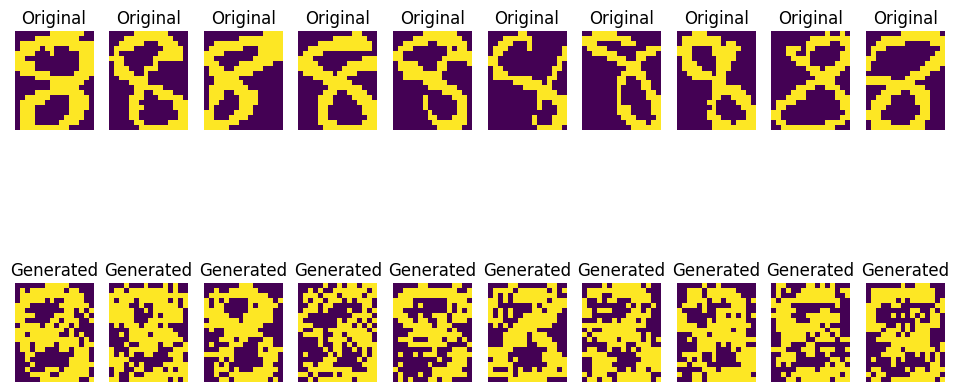

In [5]:
# Generate samples
generated_samples = rbm.generate_image(n_samples=10, n_gibbs_steps=1)

plot_original_and_generated_images(data_alpha, generated_samples, **{"cmap":None})

### DBN

In [6]:
data_alpha = data_alpha_1
n_chars = data_alpha.shape[0] / 39

# Parameters
n_visible = data_alpha.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)
hidden_layer_sizes = [200, 200, 200]

learning_rate = 0.1
n_epochs = 100
batch_size = int(8 * n_chars)

dbn = DBN(n_visible=n_visible, hidden_layer_sizes=hidden_layer_sizes, random_state=SEED)
dbn.train(data_alpha, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size)

Training RBM layers: 100%|██████████| 3/3 [00:03<00:00,  1.13s/layer]


DBN([
 RBM(n_visible=320, n_hidden=200),
 RBM(n_visible=200, n_hidden=200),
 RBM(n_visible=200, n_hidden=200)
])

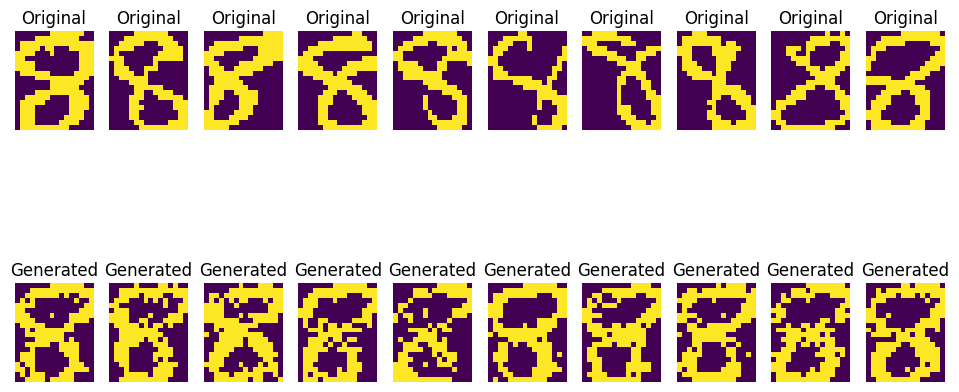

In [7]:
# # Generate images
generated_images = dbn.generate_image(n_samples=10, n_gibbs_steps=1)

# Display generated images
plot_original_and_generated_images(data_alpha, generated_images, **{"cmap":None})

### MNIST

In [8]:
import scipy.io

In [9]:
def load_mnist(mnist_path, mnist_dict=None, use_dict=False):
    if not use_dict:
        mnist_dict = scipy.io.loadmat(mnist_path)
    
    X_train = np.concatenate([mnist_dict[f"train{i}"] for i in range(10)], axis=0)
    X_test = np.concatenate([mnist_dict[f"test{i}"] for i in range(10)], axis=0)
    
    y_train = np.concatenate([np.eye(10)[[i]*mnist_dict[f"train{i}"].shape[0]] for i in range(10)], axis=0)
    y_test = np.concatenate([np.eye(10)[[i]*mnist_dict[f"test{i}"].shape[0]] for i in range(10)], axis=0)

    return X_train, y_train, X_test, y_test


def sample_indices(data_size: int, sample_size: int, random_state=None) -> np.ndarray:
    """
    Randomly sample indices from the range [0, data_size) without replacement.

    Parameters:
        data_size (int): Total number of indices available.
        sample_size (int): Number of indices to sample.
        random_state: Random seed for reproducibility.

    Returns:
        numpy.ndarray: Array of sampled indices.
    """
    rng = np.random.default_rng(random_state)
    if sample_size >= data_size:
        return np.arange(data_size)

    sampled_indices = rng.choice(data_size, size=sample_size, replace=False)
    return sampled_indices

def sample_mnist(X_train: np.ndarray, y_train: np.ndarray, sample_size: int, random_state=None) -> tuple:
    """
    Randomly sample a subset of samples from the MNIST dataset.

    Parameters:
        X_train (numpy.ndarray): Training data.
        y_train (numpy.ndarray): Training labels.
        sample_size (int): Number of samples to sample.
        random_state: Random seed for reproducibility.

    Returns:
        tuple: Sampled subset of training data and labels.
    """
    # Sample indices
    indices = sample_indices(len(X_train), sample_size, random_state=random_state)
    
    # Sample data and labels
    sampled_X_train = X_train[indices]
    sampled_y_train = y_train[indices]
    
    return sampled_X_train, sampled_y_train


def binarize_images(images):
    threshold = 127
    binary_images = np.where(images > threshold, 1, 0)
    return binary_images

mnist_train, mnist_train_labels, mnist_test, mnist_test_labels = (
    load_mnist(MNIST_PATH)
)


# Binarize the images
binary_mnist_train = binarize_images(mnist_train)
binary_mnist_test = binarize_images(mnist_test)


[mnist.shape for mnist in (mnist_train, mnist_train_labels, mnist_test, mnist_test_labels)]

[(60000, 784), (60000, 10), (10000, 784), (10000, 10)]

In [10]:
mnist_train_30000, mnist_train_labels_30000 = sample_mnist(mnist_train, mnist_train_labels, 30_000, 42)
mnist_train_30000.shape, mnist_train_labels_30000.shape

((30000, 784), (30000, 10))

In [11]:
print(mnist_train.max(), binary_mnist_train.max())

255 1


MNIST (60000, 28, 28)


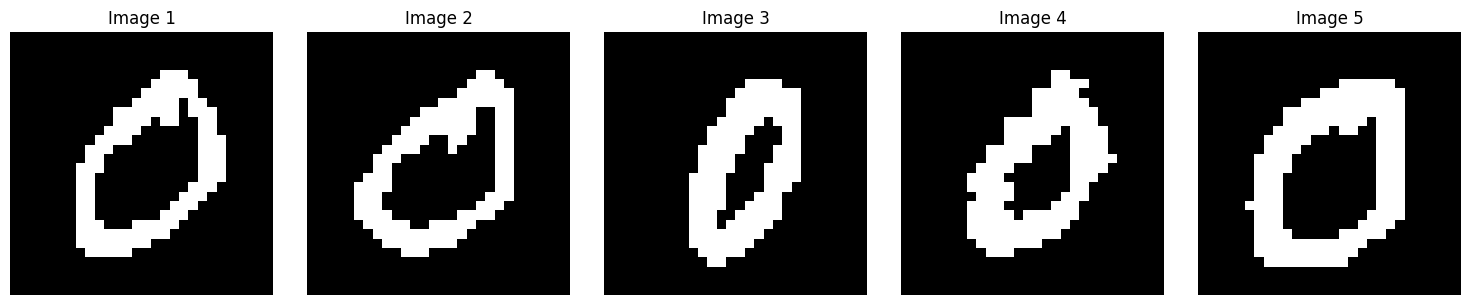

In [12]:
# Reshape mnist_train to its original shape
image_height = 28
image_width = 28
num_samples = binary_mnist_train.shape[0]
binary_mnist_train_images = binary_mnist_train.reshape(num_samples, image_height, image_width)
print("MNIST", binary_mnist_train_images.shape)

# Plot some images from mnist_train
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))
for i in range(num_images_to_plot):
    axes[i].imshow(binary_mnist_train_images[i], cmap='gray')
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
help(DNN)

Help on class DNN in module models.principal_dnn_mnist:

class DNN(models.principal_dbn_alpha.DBN)
 |  DNN(input_dim: int, output_dim: int, hidden_layer_sizes: List[int], random_state=None)
 |  
 |  Method resolution order:
 |      DNN
 |      models.principal_dbn_alpha.DBN
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, key)
 |  
 |  __init__(self, input_dim: int, output_dim: int, hidden_layer_sizes: List[int], random_state=None)
 |      Initialize the Deep Neural Network (DNN).
 |      
 |      Parameters:
 |      - input_dim (int): Dimension of the input.
 |      - output_dim (int): Dimension of the output.
 |      - hidden_layer_sizes (List[int]): List of sizes for each hidden layer.
 |      - random_state: Random seed for reproducibility.
 |  
 |  __len__(self)
 |  
 |  __repr__(self)
 |      Return a string representation of the DBN object.
 |  
 |  backpropagation(self, input_data: numpy.ndarray, labels: numpy.ndarray, n_epochs: int = 100, learn

In [14]:
from typing import Tuple

def run_experiment_dnn(
    # data
    train_data,
    train_labels,
    test_data,
    test_labels,
    # initialization
    input_dim,
    output_dim,
    hidden_layer_sizes,
    # training
    batch_size=64,
    n_epochs_pretrain=100,
    n_epochs_backprop=200,
    learning_rate=0.1,
    eps=1e-15,
    print_each=20,
    verbose=True,
    random_state=42,     
) -> Tuple[float, float]:
    """
    Run an experiment with Deep Neural Networks (DNNs).

    Parameters:
        train_data (numpy.ndarray): Training data.
        train_labels (numpy.ndarray): Training labels.
        test_data (numpy.ndarray): Test data.
        test_labels (numpy.ndarray): Test labels.
        input_dim (int): Dimensionality of input data.
        output_dim (int): Dimensionality of output data.
        hidden_layer_sizes (list): List of sizes of hidden layers.
        random_state (int): Random seed for reproducibility. Default is 42.
        n_epochs_pretrain (int): Number of epochs for pretraining. Default is 100.
        n_epochs_backprop (int): Number of epochs for backpropagation. Default is 200.
        learning_rate (float): Learning rate for training. Default is 0.1.
        batch_size (int): Batch size for training. Default is 64.
        print_each (int): Frequency of printing progress. Default is 20.
        verbose (bool): Whether to print progress. Default is True.
        eps (float): Small value to avoid division by zero. Default is 1e-15.

    Returns:
        Tuple[float, float]: Error rates for random initialization and pretrained models.
    """
    # 1. Intialization.
    dnn = DNN(
            input_dim=input_dim, 
            output_dim=output_dim, 
            hidden_layer_sizes=hidden_layer_sizes,
            random_state=random_state
    )

    ## 1.1 Initialized random weights DNN.
    dnn_random_init = dnn.copy()
    
    ## 1.2.1 Pretrain DBN component.
    dnn.pretrain(
            n_epochs=n_epochs_pretrain,
            learning_rate=learning_rate,
            batch_size=batch_size,
            data=train_data,
            print_each=print_each,
            verbose=verbose
    )
    ## 1.2.2 Initialized pre-trained DNN.                
    dnn_pretrained = dnn.copy()

    # 2. Training phase (backpropagation).
    backprop_params = {
            "input_data": train_data, 
            "labels": train_labels, 
            "n_epochs": n_epochs_backprop, 
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "print_each": print_each,
            "verbose": verbose, 
            "eps": eps
    }
    dnn_random_init.backpropagation(**backprop_params)
    dnn_pretrained.backpropagation(**backprop_params)

    # 3. Evaluation phase.
    test_params = {"test_data": test_data, "true_labels": test_labels}
    error_rate_random_init = dnn_random_init.test(**test_params)
    error_rate_pretrained = dnn_pretrained.test(**test_params)

    return error_rate_random_init, error_rate_pretrained


import pickle

def save_object(obj, file_path):
    """
    Save an object to a file using pickle.

    Parameters:
        obj: The object to save.
        file_path (str): The path to the file where the object will be saved.
    """
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)



import os

def save_results(error_rate_random_init, error_rate_pretrained, experiment_type, parameter_value, hidden_layer_sizes, train_size, save_dir):
    """
    Save experiment results to a file.

    Parameters:
        error_rate_random_init (float): Error rate for randomly initialized networks.
        error_rate_pretrained (float): Error rate for pretrained networks.
        experiment_type (str): Type of experiment ('layers', 'neurons', 'train_size').
        parameter_value: Value of the parameter being varied.
        hidden_layer_sizes (list): Sizes of hidden layers.
        train_size (int): Number of training data points.
        save_dir (str): Directory to save the results.
    """
    # Create directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Construct filename
    filename = f"error_rates_{experiment_type}_{parameter_value}_{len(hidden_layer_sizes)}layers_{'_'.join(map(str, hidden_layer_sizes))}_{train_size}.txt"
    filepath = os.path.join(save_dir, filename)

    # Save results to file
    with open(filepath, 'w') as file:
        file.write("Error Rate for Random Initialization:\n")
        file.write(f"{error_rate_random_init}\n")

        file.write("\nError Rate for Pretrained Networks:\n")
        file.write(f"{error_rate_pretrained}\n")

    print(f"Results saved to: {filepath}")



In [15]:
def experiment_layers(train_data, train_labels, test_data, test_labels, save_dir):
    num_layers = [2, 3, 4, 5]  # Number of layers
    error_rates_random_init = []
    error_rates_pretrained = []

    for num_layer in num_layers:
        hidden_layer_sizes = [200] * num_layer
        error_rate_random_init, error_rate_pretrained = run_experiment_dnn(
            train_data=train_data, train_labels=train_labels,
            test_data=test_data, test_labels=test_labels,
            input_dim=train_data.shape[1], output_dim=len(np.unique(train_labels)),
            hidden_layer_sizes=hidden_layer_sizes,
        )
        error_rates_random_init.append(error_rate_random_init)
        error_rates_pretrained.append(error_rate_pretrained)
        save_results(error_rates_random_init, error_rates_pretrained,
                     'layers', num_layer, hidden_layer_sizes, train_data.shape[0], save_dir)
        
    return error_rates_random_init, error_rates_pretrained

def experiment_neurons(
        train_data,
        train_labels,
        test_data,
        test_labels,
        save_dir,
        layer_sizes = [200, 300, 400, 500]
    ):
    error_rates_random_init = []
    error_rates_pretrained = []

    for layer_size in layer_sizes:
        hidden_layer_sizes = [layer_size] * 2  # Fixed to 2 layers
        error_rate_random_init, error_rate_pretrained = run_experiment_dnn(
            train_data=train_data, train_labels=train_labels,
            test_data=test_data, test_labels=test_labels,
            input_dim=train_data.shape[1], output_dim=len(np.unique(train_labels)),
            hidden_layer_sizes=hidden_layer_sizes,
        )
        error_rates_random_init.append(error_rate_random_init)
        error_rates_pretrained.append(error_rate_pretrained)
        save_results(error_rates_random_init, error_rates_pretrained,
                     'neurons', layer_size, hidden_layer_sizes, train_data.shape[0], save_dir)
        

    return error_rates_random_init, error_rates_pretrained


def experiment_train_size(
        train_data,
        train_labels,
        test_data,
        test_labels,
        save_dir, 
        train_sizes = [1000, 3000, 7000, 10000, 30000, 60000]
    ):
      # Number of training data points
    error_rates_random_init = []
    error_rates_pretrained = []

    for train_size in train_sizes:
        sampled_train_data, sampled_train_labels = sample_mnist(train_data, train_labels, train_size)
        error_rate_random_init, error_rate_pretrained = run_experiment_dnn(
            train_data=sampled_train_data, train_labels=sampled_train_labels,
            test_data=test_data, test_labels=test_labels,
            input_dim=sampled_train_data.shape[1], output_dim=len(np.unique(train_labels)),
            hidden_layer_sizes=[200, 200],  # Fixed to 2 layers of 200 neurons
        )
        error_rates_random_init.append(error_rate_random_init)
        error_rates_pretrained.append(error_rate_pretrained)
        save_results(error_rates_random_init, error_rates_pretrained,
                     'train_size', train_size, [200, 200], train_data.shape[0], save_dir)

    return error_rates_random_init, error_rates_pretrained



In [19]:
data = mnist_train.copy()
n_samples, n_visible = data.shape # n_samples, n_features
n_visible = data.shape[1]
hidden_layer_sizes = [100, 50, 25]
n_classes = mnist_test_labels.shape[1]

dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)

# dnn.train(data, learning_rate=0.1, n_epochs=10, batch_size=10)


In [18]:
# dnn.backpropagation(mnist_train, labels=mnist_train_labels)